In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import sys
sys.tracebacklimit = 0

import numpy as np
import networkx as nx 
import matplotlib.pyplot as plt

In [3]:
from pettingzoo.test import parallel_api_test
from solution.custom_gym import CustomGymEnviornment
from solution.trainer import *
from solution.policy_net import *

In [4]:
from core.agent import *
from core.world import * 
from core.render import * 
from core.skill import * 
from core.models import *
from core.message import *

In [5]:
DEVICE = "cuda"

In [6]:
from sar.sar_agent import *
from sar.sar_world import *
from sar.sar_env_params import *
from sar.sar_traits_sampler import *

belief_initializer = SARBeliefInitializer(BELIEF_DIMS)
trait_sampler = SARTraitSampler()

def initialize_swarm(world : BaseWorld):
    swarm = trait_sampler.generate(SWARM_SIZE, DEVICE)
    for agent in swarm:
        agent.set_utility(SARUtilityFunction())
        world.add_agent(agent)
    swarm = initialize_positions_randomly(world, swarm)
    swarm = belief_initializer.initialize_beliefs(swarm)

In [7]:

from sar.urban_gen import * 
from sar.victims import * 
from sar.sar_comm import * 

terrain_generator = UrbanTerrainMapGenerator(padding = MAX_VISIBILITY)
victim_generator = VictimGenerator(padding = MAX_VISIBILITY)
def initialize_terrain(world : BaseWorld):
    terrain_map, population_map = terrain_generator.generate(world._dims)
    map_collection : BaseMapCollection = BaseMapCollection()
    map_collection.add_map("Terrain", terrain_map)
    map_collection.add_map("Population", population_map)

    victim_generator.set_density_map(population_map)
    victim_map = victim_generator.generate(world._dims)

    map_collection.add_map("Victims", victim_map)
    return map_collection


In [8]:
from sar.energy import EnergyModel
from sar.victims import VictimModel
from solution.sar_action_interpreter import *
from solution.encoder_net import *
from solution.decoder_net import *
from models.complex_model import * 

world = SARWorld(dims = WORLD_DIMS,
              swarm_initializer= initialize_swarm,
              generation_pipeline=initialize_terrain
              )
world.add_model("energy_model", EnergyModel())
world.add_model("victim_model", VictimModel())
world.reset()

In [9]:
policy_net= PolicyNet(1, 7, 4)
target_net=  PolicyNet(1, 7, 4)
encoder_model = Encoder()
decoder_model = Decoder()

complex_model = ComplexModel(
    policy_net= policy_net, 
    encoder_net = encoder_model, 
    decoder_net = decoder_model
)

comms_protocol = SARCommunicationProtocol(encoder_model, decoder_model)
action_interpreter = SARActionInterpreter(BELIEF_DIMS)

custom_gym : CustomGymEnviornment = CustomGymEnviornment(world, action_interpreter, comms_protocol)

complex_model.to(DEVICE)
custom_gym.to(DEVICE)

In [10]:
custom_gym.reset(42)

({1: {'Belief': tensor([0., 0., 0., 0., 0.], device='cuda:0'),
   'Vision': array([[1., 1., 1., 0., 1., 0., 1.],
          [1., 0., 0., 0., 1., 1., 1.],
          [1., 0., 0., 1., 0., 0., 1.],
          [0., 1., 0., 0., 0., 1., 0.],
          [1., 0., 0., 1., 0., 0., 1.],
          [0., 1., 0., 0., 0., 0., 0.],
          [1., 1., 0., 0., 1., 0., 1.]]),
   'State': tensor([90.3885,  0.0000], device='cuda:0')},
  2: {'Belief': tensor([0., 0., 0., 0., 0.], device='cuda:0'),
   'Vision': array([[1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 0., 1.],
          [1., 1., 1., 1., 0., 1., 1.],
          [1., 0., 1., 0., 0., 1., 0.],
          [1., 1., 1., 1., 0., 1., 0.],
          [1., 0., 0., 0., 0., 0., 1.],
          [1., 1., 0., 1., 1., 0., 0.]]),
   'State': tensor([107.1394,   1.0000], device='cuda:0')},
  3: {'Belief': tensor([0., 0., 0., 0., 0.], device='cuda:0'),
   'Vision': array([[0., 0., 0., 0., 1., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0.],
          [1., 1., 

### Testing

In [11]:
parallel_api_test(custom_gym, num_cycles=1_000)
custom_gym.reset()

Passed Parallel API test


({1: {'Belief': tensor([0., 0., 0., 0., 0.], device='cuda:0'),
   'Vision': array([[1., 1., 1., 0., 1., 0., 1.],
          [1., 0., 0., 0., 1., 1., 1.],
          [1., 0., 0., 1., 0., 0., 1.],
          [0., 1., 0., 0., 0., 1., 0.],
          [1., 0., 0., 1., 0., 0., 1.],
          [0., 1., 0., 0., 0., 0., 0.],
          [1., 1., 0., 0., 1., 0., 1.]]),
   'State': tensor([90.3885,  0.0000], device='cuda:0')},
  2: {'Belief': tensor([0., 0., 0., 0., 0.], device='cuda:0'),
   'Vision': array([[1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 0., 1.],
          [1., 1., 1., 1., 0., 1., 1.],
          [1., 0., 1., 0., 0., 1., 0.],
          [1., 1., 1., 1., 0., 1., 0.],
          [1., 0., 0., 0., 0., 0., 1.],
          [1., 1., 0., 1., 1., 0., 0.]]),
   'State': tensor([107.1394,   1.0000], device='cuda:0')},
  3: {'Belief': tensor([0., 0., 0., 0., 0.], device='cuda:0'),
   'Vision': array([[0., 0., 0., 0., 1., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0.],
          [1., 1., 

# Training

In [12]:

from models.base import * 
from models.idqn import * 
from solution.policy_net import PolicyNet
import matplotlib.pyplot as plt

In [13]:
model = IDQN(env = custom_gym,
             feature_extractor= feature_extractor,
             target_net= target_net,
             model= complex_model,
             batch_size=1024,
             device = DEVICE
             )

In [14]:
rewards = train_loop(custom_gym, model, games=10, optimization_passes = 1, seed=42)

Training on thesis.


Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Joaquin\miniconda3\envs\thesis\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([1, 1024])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average loss 60.5000256562233
Model has been saved.

Starting evaluation on thesis (num_games=1)


Training Progress:  10%|█         | 1/10 [00:21<03:11, 21.25s/it]

Avg reward: 959.73  std: 386.5621516651624  coeff : 0.4027821904756154
Avg reward per agent, per game:  {1: 1427.0, 2: 799.0, 3: 1876.0, 4: 1338.0, 5: 1487.0, 6: 1154.0, 7: 557.0, 8: 786.0, 9: 795.0, 10: 1528.0, 11: 436.0, 12: 1300.0, 13: 910.0, 14: 1270.0, 15: 1315.0, 16: 982.0, 17: 877.0, 18: 705.0, 19: 2087.0, 20: 955.0, 21: 859.0, 22: 1178.0, 23: 1211.0, 24: 557.0, 25: 1162.0, 26: 1068.0, 27: 1645.0, 28: 368.0, 29: 1415.0, 30: 635.0, 31: 524.0, 32: 669.0, 33: 402.0, 34: 619.0, 35: 1400.0, 36: 543.0, 37: 594.0, 38: 784.0, 39: 1434.0, 40: 1486.0, 41: 590.0, 42: 851.0, 43: 909.0, 44: 719.0, 45: 1140.0, 46: 953.0, 47: 806.0, 48: 987.0, 49: 172.0, 50: 888.0, 51: 1888.0, 52: 1350.0, 53: 1202.0, 54: 750.0, 55: 372.0, 56: 746.0, 57: 931.0, 58: 1348.0, 59: 1436.0, 60: 1291.0, 61: 382.0, 62: 955.0, 63: 962.0, 64: 1078.0, 65: 761.0, 66: 1003.0, 67: 919.0, 68: 569.0, 69: 222.0, 70: 471.0, 71: 1141.0, 72: 757.0, 73: 1353.0, 74: 881.0, 75: 1241.0, 76: 869.0, 77: 417.0, 78: 1328.0, 79: 543.0, 80:

Training Progress:  20%|██        | 2/10 [00:50<03:29, 26.24s/it]

Avg reward: 1037.93  std: 404.2156665692214  coeff : 0.3894440536155824
Avg reward per agent, per game:  {1: 1509.0, 2: 1144.0, 3: 1369.0, 4: 1693.0, 5: 1390.0, 6: 1420.0, 7: 754.0, 8: 1193.0, 9: 1357.0, 10: 470.0, 11: 1693.0, 12: 1175.0, 13: 1293.0, 14: 1795.0, 15: 1346.0, 16: 1148.0, 17: 859.0, 18: 1711.0, 19: 1740.0, 20: 1380.0, 21: 823.0, 22: 1138.0, 23: 1519.0, 24: 421.0, 25: 1475.0, 26: 897.0, 27: 1688.0, 28: 1137.0, 29: 1035.0, 30: 708.0, 31: 573.0, 32: 1116.0, 33: 627.0, 34: 493.0, 35: 930.0, 36: 797.0, 37: 575.0, 38: 842.0, 39: 1568.0, 40: 1669.0, 41: 805.0, 42: 1204.0, 43: 792.0, 44: 726.0, 45: 799.0, 46: 1517.0, 47: 1154.0, 48: 1074.0, 49: 263.0, 50: 1098.0, 51: 1549.0, 52: 455.0, 53: 1124.0, 54: 904.0, 55: 490.0, 56: 653.0, 57: 652.0, 58: 899.0, 59: 1701.0, 60: 411.0, 61: 686.0, 62: 832.0, 63: 1108.0, 64: 693.0, 65: 860.0, 66: 1477.0, 67: 754.0, 68: 517.0, 69: 697.0, 70: 1471.0, 71: 915.0, 72: 826.0, 73: 850.0, 74: 608.0, 75: 1335.0, 76: 1674.0, 77: 957.0, 78: 1448.0, 79: 1

Training Progress:  30%|███       | 3/10 [01:22<03:19, 28.53s/it]

Avg reward: 959.72  std: 428.29571746633195  coeff : 0.4462715348917725
Avg reward per agent, per game:  {1: 1641.0, 2: 1095.0, 3: 1799.0, 4: 1486.0, 5: 1107.0, 6: 922.0, 7: 900.0, 8: 1926.0, 9: 962.0, 10: 491.0, 11: 950.0, 12: 1398.0, 13: 784.0, 14: 1674.0, 15: 1144.0, 16: 1493.0, 17: 943.0, 18: 623.0, 19: 1272.0, 20: 770.0, 21: 959.0, 22: 1459.0, 23: 807.0, 24: 882.0, 25: 585.0, 26: 842.0, 27: 1690.0, 28: 890.0, 29: 1222.0, 30: 580.0, 31: 855.0, 32: 919.0, 33: 921.0, 34: 663.0, 35: 1233.0, 36: 938.0, 37: 552.0, 38: 1392.0, 39: 2080.0, 40: 774.0, 41: 554.0, 42: 715.0, 43: 953.0, 44: 658.0, 45: 1249.0, 46: 1750.0, 47: 869.0, 48: 651.0, 49: 407.0, 50: 863.0, 51: 1656.0, 52: 265.0, 53: 1372.0, 54: 227.0, 55: 156.0, 56: 568.0, 57: 197.0, 58: 1522.0, 59: 1061.0, 60: 688.0, 61: 717.0, 62: 704.0, 63: 1599.0, 64: 779.0, 65: 799.0, 66: 1238.0, 67: 867.0, 68: 975.0, 69: 554.0, 70: 294.0, 71: 1210.0, 72: 689.0, 73: 938.0, 74: 579.0, 75: 746.0, 76: 1934.0, 77: 652.0, 78: 1780.0, 79: 653.0, 80: 66

Training Progress:  40%|████      | 4/10 [01:53<02:56, 29.44s/it]

Avg reward: 1053.56  std: 428.2291050360776  coeff : 0.40645915281149403
Avg reward per agent, per game:  {1: 1777.0, 2: 751.0, 3: 1055.0, 4: 1576.0, 5: 1705.0, 6: 1691.0, 7: 821.0, 8: 1322.0, 9: 1592.0, 10: 1008.0, 11: 549.0, 12: 1154.0, 13: 1285.0, 14: 1307.0, 15: 1011.0, 16: 1346.0, 17: 1324.0, 18: 889.0, 19: 2101.0, 20: 722.0, 21: 670.0, 22: 1480.0, 23: 1221.0, 24: 867.0, 25: 780.0, 26: 670.0, 27: 1142.0, 28: 663.0, 29: 1220.0, 30: 516.0, 31: 798.0, 32: 962.0, 33: 658.0, 34: 534.0, 35: 1113.0, 36: 775.0, 37: 544.0, 38: 1321.0, 39: 1074.0, 40: 1506.0, 41: 1448.0, 42: 1411.0, 43: 1252.0, 44: 1224.0, 45: 542.0, 46: 1136.0, 47: 1252.0, 48: 964.0, 49: 223.0, 50: 879.0, 51: 1787.0, 52: 374.0, 53: 1283.0, 54: 587.0, 55: 699.0, 56: 376.0, 57: 476.0, 58: 1520.0, 59: 1378.0, 60: 1265.0, 61: 636.0, 62: 1017.0, 63: 2047.0, 64: 1076.0, 65: 1197.0, 66: 1629.0, 67: 540.0, 68: 567.0, 69: 845.0, 70: 1066.0, 71: 1553.0, 72: 912.0, 73: 1080.0, 74: 399.0, 75: 574.0, 76: 1332.0, 77: 1884.0, 78: 1640.0,

Training Progress:  50%|█████     | 5/10 [02:17<02:17, 27.53s/it]

Avg reward: 979.36  std: 382.308684703866  coeff : 0.39036583554960996
Avg reward per agent, per game:  {1: 1374.0, 2: 711.0, 3: 1504.0, 4: 1760.0, 5: 1102.0, 6: 1005.0, 7: 1036.0, 8: 1303.0, 9: 668.0, 10: 554.0, 11: 633.0, 12: 1105.0, 13: 642.0, 14: 1538.0, 15: 1493.0, 16: 1296.0, 17: 994.0, 18: 1085.0, 19: 1353.0, 20: 1284.0, 21: 645.0, 22: 1424.0, 23: 899.0, 24: 878.0, 25: 698.0, 26: 641.0, 27: 1329.0, 28: 899.0, 29: 1443.0, 30: 381.0, 31: 588.0, 32: 1052.0, 33: 927.0, 34: 768.0, 35: 862.0, 36: 700.0, 37: 961.0, 38: 577.0, 39: 1657.0, 40: 1124.0, 41: 1421.0, 42: 891.0, 43: 998.0, 44: 865.0, 45: 628.0, 46: 1855.0, 47: 1220.0, 48: 615.0, 49: 230.0, 50: 1337.0, 51: 1590.0, 52: 808.0, 53: 890.0, 54: 531.0, 55: 246.0, 56: 854.0, 57: 1276.0, 58: 828.0, 59: 1389.0, 60: 603.0, 61: 759.0, 62: 994.0, 63: 741.0, 64: 1027.0, 65: 341.0, 66: 1295.0, 67: 1096.0, 68: 806.0, 69: 559.0, 70: 1401.0, 71: 999.0, 72: 465.0, 73: 1580.0, 74: 851.0, 75: 780.0, 76: 2024.0, 77: 829.0, 78: 731.0, 79: 824.0, 80

Training Progress:  60%|██████    | 6/10 [02:46<01:52, 28.09s/it]

Avg reward: 968.4  std: 443.57337611718765  coeff : 0.45804768289672415
Avg reward per agent, per game:  {1: 514.0, 2: 1153.0, 3: 1609.0, 4: 777.0, 5: 1906.0, 6: 1262.0, 7: 494.0, 8: 1598.0, 9: 778.0, 10: 557.0, 11: 1044.0, 12: 1183.0, 13: 1009.0, 14: 1275.0, 15: 677.0, 16: 708.0, 17: 1187.0, 18: 515.0, 19: 1698.0, 20: 1296.0, 21: 498.0, 22: 1090.0, 23: 885.0, 24: 469.0, 25: 919.0, 26: 670.0, 27: 843.0, 28: 932.0, 29: 1095.0, 30: 752.0, 31: 702.0, 32: 896.0, 33: 834.0, 34: 715.0, 35: 1137.0, 36: 360.0, 37: 717.0, 38: 680.0, 39: 1854.0, 40: 1566.0, 41: 498.0, 42: 697.0, 43: 1191.0, 44: 938.0, 45: 1338.0, 46: 1093.0, 47: 784.0, 48: 490.0, 49: 127.0, 50: 619.0, 51: 2835.0, 52: 925.0, 53: 1970.0, 54: 283.0, 55: 710.0, 56: 677.0, 57: 773.0, 58: 1557.0, 59: 1202.0, 60: 437.0, 61: 1072.0, 62: 710.0, 63: 1798.0, 64: 1083.0, 65: 532.0, 66: 1151.0, 67: 696.0, 68: 573.0, 69: 1630.0, 70: 1414.0, 71: 1499.0, 72: 739.0, 73: 866.0, 74: 857.0, 75: 713.0, 76: 1619.0, 77: 914.0, 78: 1225.0, 79: 842.0, 8

Training Progress:  70%|███████   | 7/10 [03:16<01:25, 28.61s/it]

Avg reward: 1046.89  std: 444.85451318380484  coeff : 0.424929565841497
Avg reward per agent, per game:  {1: 1977.0, 2: 902.0, 3: 1140.0, 4: 1581.0, 5: 1373.0, 6: 1301.0, 7: 1447.0, 8: 875.0, 9: 1508.0, 10: 1340.0, 11: 1158.0, 12: 526.0, 13: 1118.0, 14: 1377.0, 15: 1464.0, 16: 980.0, 17: 1830.0, 18: 840.0, 19: 2137.0, 20: 1371.0, 21: 1040.0, 22: 995.0, 23: 934.0, 24: 817.0, 25: 1514.0, 26: 1107.0, 27: 857.0, 28: 646.0, 29: 1560.0, 30: 519.0, 31: 434.0, 32: 1304.0, 33: 1115.0, 34: 668.0, 35: 974.0, 36: 489.0, 37: 680.0, 38: 559.0, 39: 1950.0, 40: 1396.0, 41: 1303.0, 42: 1743.0, 43: 887.0, 44: 736.0, 45: 693.0, 46: 1572.0, 47: 942.0, 48: 808.0, 49: 309.0, 50: 718.0, 51: 2399.0, 52: 886.0, 53: 1435.0, 54: 637.0, 55: 716.0, 56: 736.0, 57: 374.0, 58: 2196.0, 59: 1392.0, 60: 906.0, 61: 705.0, 62: 1092.0, 63: 1216.0, 64: 927.0, 65: 721.0, 66: 1724.0, 67: 627.0, 68: 330.0, 69: 374.0, 70: 1563.0, 71: 1272.0, 72: 382.0, 73: 1241.0, 74: 490.0, 75: 729.0, 76: 1552.0, 77: 827.0, 78: 1350.0, 79: 696

Training Progress:  80%|████████  | 8/10 [03:46<00:58, 29.24s/it]

Avg reward: 1028.03  std: 415.41748771567137  coeff : 0.40409082197569274
Avg reward per agent, per game:  {1: 1519.0, 2: 1070.0, 3: 1640.0, 4: 1037.0, 5: 1485.0, 6: 699.0, 7: 645.0, 8: 946.0, 9: 743.0, 10: 615.0, 11: 1007.0, 12: 2110.0, 13: 793.0, 14: 1415.0, 15: 1487.0, 16: 954.0, 17: 1290.0, 18: 629.0, 19: 2199.0, 20: 1479.0, 21: 472.0, 22: 1078.0, 23: 948.0, 24: 999.0, 25: 1402.0, 26: 780.0, 27: 1172.0, 28: 563.0, 29: 2009.0, 30: 820.0, 31: 821.0, 32: 1489.0, 33: 1014.0, 34: 796.0, 35: 1086.0, 36: 560.0, 37: 565.0, 38: 1349.0, 39: 1278.0, 40: 1363.0, 41: 863.0, 42: 1129.0, 43: 1172.0, 44: 883.0, 45: 784.0, 46: 947.0, 47: 1584.0, 48: 911.0, 49: 337.0, 50: 1417.0, 51: 1713.0, 52: 717.0, 53: 1034.0, 54: 851.0, 55: 636.0, 56: 522.0, 57: 680.0, 58: 1738.0, 59: 929.0, 60: 674.0, 61: 898.0, 62: 692.0, 63: 1398.0, 64: 1497.0, 65: 362.0, 66: 1253.0, 67: 1532.0, 68: 718.0, 69: 687.0, 70: 1088.0, 71: 1072.0, 72: 620.0, 73: 1359.0, 74: 330.0, 75: 469.0, 76: 2089.0, 77: 1170.0, 78: 1053.0, 79: 

Training Progress:  90%|█████████ | 9/10 [04:15<00:29, 29.04s/it]

Avg reward: 1033.51  std: 440.1374216082972  coeff : 0.4258666308098588
Avg reward per agent, per game:  {1: 562.0, 2: 585.0, 3: 1540.0, 4: 1692.0, 5: 1632.0, 6: 1173.0, 7: 773.0, 8: 1347.0, 9: 1255.0, 10: 565.0, 11: 549.0, 12: 1367.0, 13: 1134.0, 14: 1318.0, 15: 1512.0, 16: 1116.0, 17: 995.0, 18: 1220.0, 19: 1748.0, 20: 1464.0, 21: 827.0, 22: 1322.0, 23: 1810.0, 24: 729.0, 25: 785.0, 26: 423.0, 27: 1426.0, 28: 1125.0, 29: 1588.0, 30: 1199.0, 31: 790.0, 32: 1351.0, 33: 1134.0, 34: 924.0, 35: 829.0, 36: 947.0, 37: 1162.0, 38: 778.0, 39: 1736.0, 40: 1125.0, 41: 898.0, 42: 1841.0, 43: 1071.0, 44: 644.0, 45: 938.0, 46: 2199.0, 47: 1499.0, 48: 959.0, 49: 594.0, 50: 1210.0, 51: 1859.0, 52: 867.0, 53: 1192.0, 54: 544.0, 55: 459.0, 56: 574.0, 57: 197.0, 58: 930.0, 59: 1090.0, 60: 1106.0, 61: 417.0, 62: 810.0, 63: 773.0, 64: 1125.0, 65: 868.0, 66: 1378.0, 67: 992.0, 68: 675.0, 69: 360.0, 70: 475.0, 71: 1366.0, 72: 905.0, 73: 1381.0, 74: 1131.0, 75: 332.0, 76: 1636.0, 77: 644.0, 78: 1684.0, 79: 

Training Progress: 100%|██████████| 10/10 [04:44<00:00, 28.42s/it]

Avg reward: 1035.68  std: 466.8170708103978  coeff : 0.4507348513154621
Avg reward per agent, per game:  {1: 674.0, 2: 557.0, 3: 1472.0, 4: 1201.0, 5: 2512.0, 6: 1248.0, 7: 711.0, 8: 1497.0, 9: 676.0, 10: 667.0, 11: 1121.0, 12: 1244.0, 13: 1082.0, 14: 1483.0, 15: 686.0, 16: 1957.0, 17: 667.0, 18: 753.0, 19: 1503.0, 20: 1688.0, 21: 374.0, 22: 1406.0, 23: 1532.0, 24: 969.0, 25: 737.0, 26: 1247.0, 27: 1196.0, 28: 1002.0, 29: 1071.0, 30: 692.0, 31: 1219.0, 32: 1240.0, 33: 597.0, 34: 836.0, 35: 874.0, 36: 526.0, 37: 855.0, 38: 1291.0, 39: 1675.0, 40: 2160.0, 41: 567.0, 42: 1726.0, 43: 1027.0, 44: 1364.0, 45: 858.0, 46: 1168.0, 47: 1399.0, 48: 617.0, 49: 646.0, 50: 1115.0, 51: 1950.0, 52: 1104.0, 53: 1565.0, 54: 235.0, 55: 496.0, 56: 171.0, 57: 860.0, 58: 1423.0, 59: 1268.0, 60: 1489.0, 61: 820.0, 62: 1385.0, 63: 812.0, 64: 681.0, 65: 334.0, 66: 974.0, 67: 1331.0, 68: 755.0, 69: 346.0, 70: 488.0, 71: 1525.0, 72: 768.0, 73: 829.0, 74: 572.0, 75: 608.0, 76: 1524.0, 77: 1187.0, 78: 1910.0, 79: 

[autoreload of models.base failed: Traceback (most recent call last):
  File "c:\Users\Joaquin\miniconda3\envs\thesis\Lib\site-packages\IPython\extensions\autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\Joaquin\miniconda3\envs\thesis\Lib\site-packages\IPython\extensions\autoreload.py", line 471, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "c:\Users\Joaquin\miniconda3\envs\thesis\Lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1074, in get_code
  File "<frozen importlib._bootstrap_external>", line 1004, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "c:\Users\Joaquin\Desktop\Thesis-Playground\v2\models\base.py", line 223
    def re

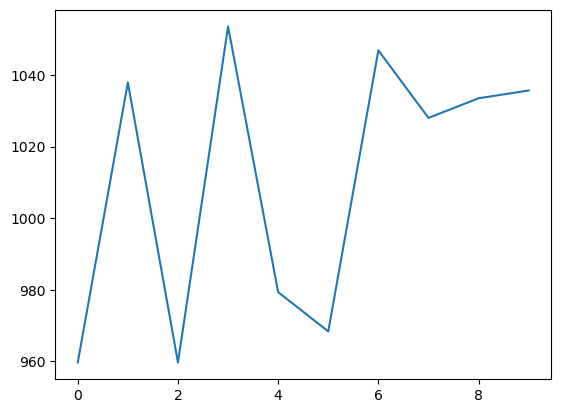

In [15]:
plt.plot(rewards)

# Optimizations

In [16]:
import cProfile

In [17]:
def stress_test():
    train_loop(custom_gym, model, games=1, optimization_passes = 1, seed=42)

In [18]:

cProfile.run('stress_test()', sort = 'time')

Training on thesis.


Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Average loss 42.42301202297211
Model has been saved.

Starting evaluation on thesis (num_games=1)


Training Progress: 100%|██████████| 1/1 [00:35<00:00, 35.98s/it]

Avg reward: 1027.37  std: 401.6360206704573  coeff : 0.39093609962375514
Avg reward per agent, per game:  {1: 1285.0, 2: 845.0, 3: 1826.0, 4: 1246.0, 5: 1153.0, 6: 1345.0, 7: 1351.0, 8: 1146.0, 9: 487.0, 10: 817.0, 11: 1018.0, 12: 1016.0, 13: 966.0, 14: 1316.0, 15: 1117.0, 16: 1117.0, 17: 1236.0, 18: 815.0, 19: 1438.0, 20: 1060.0, 21: 533.0, 22: 938.0, 23: 1541.0, 24: 950.0, 25: 1218.0, 26: 924.0, 27: 1365.0, 28: 1448.0, 29: 935.0, 30: 519.0, 31: 359.0, 32: 1250.0, 33: 832.0, 34: 781.0, 35: 602.0, 36: 630.0, 37: 585.0, 38: 1228.0, 39: 1513.0, 40: 1125.0, 41: 1235.0, 42: 2074.0, 43: 1479.0, 44: 807.0, 45: 949.0, 46: 1070.0, 47: 695.0, 48: 436.0, 49: 135.0, 50: 1208.0, 51: 2211.0, 52: 890.0, 53: 1373.0, 54: 996.0, 55: 770.0, 56: 451.0, 57: 387.0, 58: 1666.0, 59: 1576.0, 60: 736.0, 61: 541.0, 62: 979.0, 63: 1756.0, 64: 993.0, 65: 732.0, 66: 1026.0, 67: 593.0, 68: 425.0, 69: 1206.0, 70: 296.0, 71: 953.0, 72: 601.0, 73: 1114.0, 74: 822.0, 75: 988.0, 76: 1421.0, 77: 832.0, 78: 1619.0, 79: 10

# Visualization

In [ ]:
from models.base import RenderWrapper

renderer = RenderWrapper(model=model)

In [22]:
renderer.render()